Conexión al servidor usando SSH
---

In [17]:
import paramiko
import getpass
import numpy as np
home = "/home/iaraya/ibexmop3"

ssh = None
def connect(host):
    global ssh
    port = 22
    username = input("login:")
    password = getpass.getpass("pass:")

    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(host, port, username, password)
    return ssh

ssh = connect("158.251.88.197")

login: iaraya
pass: ········


----
Obtención de datos datos del solver
---
Se ejecuta `ibexmop` y se recuperan los datos de cada iteración (nodos/cajas, puntos encontrados)

In [24]:
cmd = home+"/__build__/plugins/optim-mop/ibexmop "+ home + \
                "/plugins/optim-mop/benchs/viennet2.txt --print-nds --nb_sol=n --ub=ub1 --eps=0.02"
print(cmd)
stdin, stdout, stderr = ssh.exec_command(cmd)


xdata=[]; ydata=[]; zdata=[]
iter=0
selected_box_id = {}; feasible_solutions= {}; new_boxes_id = {}; boxes = dict(); discarded_boxes=set()
flag=None
for line in stdout.readlines():
    if line.strip()=="NDS:": flag="nds"; continue
    if line.strip()=="discarded_boxes:": flag="boxes"; continue
    if line.strip()=="end": flag=None; continue 
                
    if flag=="nds":
        x, y, z = line.split()
        xdata.append(float(x))
        ydata.append(float(y))
        zdata.append(float(z))
    elif flag==None:
        sp_line = line.split(':')
        if sp_line !=  None:
            if sp_line[0]=='erase':
                if iter in feasible_solutions: 
                    feasible_solutions[iter] = np.array(feasible_solutions[iter])
                iter += 1
                selected_box_id[iter] = int(sp_line[1])
            elif sp_line[0]=='feasible_solution':
                if iter not in feasible_solutions: feasible_solutions[iter] = []
                feasible_solutions[iter].append( np.fromstring(sp_line[1], sep=' '))
            elif sp_line[0]=='insert':
                if iter not in new_boxes_id: new_boxes_id[iter] = []
                idbox = int(sp_line[1])
                boxes[idbox] =  np.fromstring(sp_line[2], sep=' ')
                new_boxes_id[iter].append( idbox )
    elif flag == "boxes":
        discarded_boxes.add(int(line))
                
if iter in feasible_solutions: 
    feasible_solutions[iter] = np.array(feasible_solutions[iter])
    
xdata=np.array(xdata)
ydata=np.array(ydata)
zdata=np.array(zdata)
print("number of points:",len(xdata))

/home/iaraya/ibexmop3/__build__/plugins/optim-mop/ibexmop /home/iaraya/ibexmop3/plugins/optim-mop/benchs/viennet2.txt --print-nds --nb_sol=n --ub=ub1 --eps=0.02
number of points: 249


Los vectores `xdata`, `ydata` y `zdata` almacenan las posiciones para los puntos de la frontera obtenida la final de la ejecución.

Aquí se grafican:

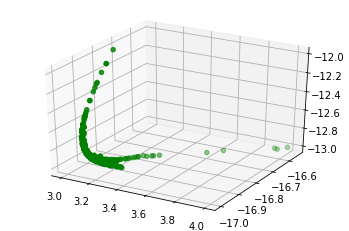

In [12]:
from mpl_toolkits import mplot3d

%matplotlib inline
#%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()

ax = plt.axes(projection='3d')

#ax.view_init(-45,-135 )
ax.scatter3D(xdata, ydata, zdata, c='g');
plt.show()

El diccionario `selected_box_id` guarda el id de la caja seleccionada en cada iteración por el solver

In [13]:
print("iterations:", len(selected_box_id))
print("box selected in second iteration:\n", boxes[selected_box_id[2]].reshape(3,2))
print("box selected in third iteration:\n", boxes[selected_box_id[3]].reshape(3,2))

iterations: 197
box selected in second iteration:
 [[  3.       11.9654 ]
 [-17.       -4.2006 ]
 [-13.       -3.58877]]
box selected in third iteration:
 [[  3.        7.03443]
 [-17.       -9.33386]
 [-13.       -4.3705 ]]


El diccionario `new_boxes_id` guarda el id de la nuevas cajas creadas durante la iteración

In [14]:
print("Cajas creadas la primera iteración:\n", boxes[new_boxes_id[1][0]].reshape(3,2), "\n\n", boxes[new_boxes_id[1][1]].reshape(3,2))

Cajas creadas la primera iteración:
 [[  3.       11.9654 ]
 [-17.       -4.2006 ]
 [-13.       -3.58877]] 

 [[ 11.9654   22.9231 ]
 [-17.       -4.2006 ]
 [-13.       -3.58877]]


El diccionario `feasible_solutions` almacena las soluciones obtenidas en cada iteración del solver.

En el siguiente ejemplo se grafican los puntos encontrados durante las iteraciones 8 y 15 del algoritmo.

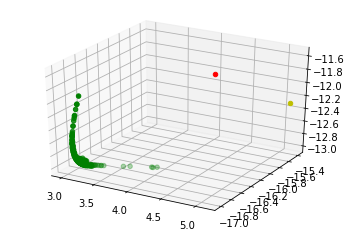

In [15]:
xx = feasible_solutions[8][:,0]
yy = feasible_solutions[8][:,1]
zz = feasible_solutions[8][:,2]

xx2 = feasible_solutions[10][:,0]
yy2 = feasible_solutions[10][:,1]
zz2 = feasible_solutions[10][:,2]

fig = plt.figure()

ax = plt.axes(projection='3d')

#ax.view_init(5,5 )
ax.scatter3D(xdata, ydata, zdata, c='g');
ax.scatter3D(xx, yy, zz, c='r');
ax.scatter3D(xx2, yy2, zz2, c='y');
plt.show()

Dibujando la superficie factible
==

Las funciones objetivo del problema definidas usando python

In [9]:
#viennet2.txt
def z1(x,y) : return ( (x-2) ** 2 ) / 2 + ( (y+1) ** 2 ) / 13 + 3
def z2(x,y) : return ( (x+y-3) ** 2 ) / 36 + ( (-x+y+2) ** 2 ) / 8 - 17
def z3(x,y) : return ( (x+2*y-1) ** 2 ) / 175 + ( (2*y-x) ** 2 ) / 17 - 13

Se grafica la región factible y la frontera obtenida (notar que la región factible es una superficie)

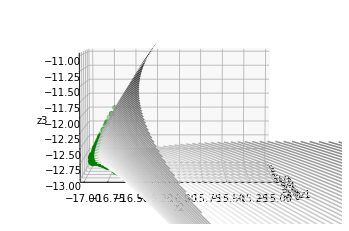

In [10]:
x = np.linspace(-2, 2, 80)
y = np.linspace(-2, 2, 80)

X, Y = np.meshgrid(x, y)
Z1 = z1(X, Y)
Z2 = z2(X, Y)
Z3 = z3(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(Z1, Z2, Z3, 100, cmap='binary')
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_zlabel('z3');
ax.set_xlim3d(3,4)
ax.set_ylim3d(-17,-15)
ax.set_zlim3d(-13,-11)
ax.view_init(5,0 )
ax.scatter3D(xdata, ydata, zdata, c='g');